# Ray start/stop

In [ ]:
ray.init(ignore_reinit_error=True)

In [ ]:
import ray
ray.shutdown()

# Imports

In [4]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("data/bokeh_output.html")

import polygon_df as pdf
import polygon_ds as pds
import polygon_s3 as ps3
import bar_samples as bs
import bar_labels as bl
import bar_meta as bm
import utils_filters as ft
from utils_pickle import pickle_dump, pickle_load

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

# import pdb; pdb.set_trace()
# import pudb; pudb.set_trace()

# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'
# pd.set_option('precision', 2)
# .plot_bokeh(sizing_mode="scale_height")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sample tick dates

In [53]:
thresh = {
    # sampling params
    'symbol': 'VTI',
    'start_date': '2020-05-01',
    'end_date': '2020-06-01',
    # mad filter
    'mad_value_winlen': 11,
    'mad_k': 22,
    'mad_deviation_winlen': 333,
    # jma filter
    'jma_winlen': 7,
    'jma_power': 2,
    # bar thresholds
    'renko_return': 'jma_return',
    'renko_size': 0.11,
    'renko_reveral_multiple': 2,
    'renko_range_frac': 22,
    'max_duration_td': dt.timedelta(minutes=33),
    'min_duration_td': dt.timedelta(seconds=33),
    'min_tick_count': 33,
    # label params
    'add_label': True,
    'label_reward_ratios': list(np.arange(2.5, 11, 0.5)),
}

symbol = thresh['symbol']
date = '2020-11-17'

VTI 2020-02-03 trying to get data from local file...


<AxesSubplot:>

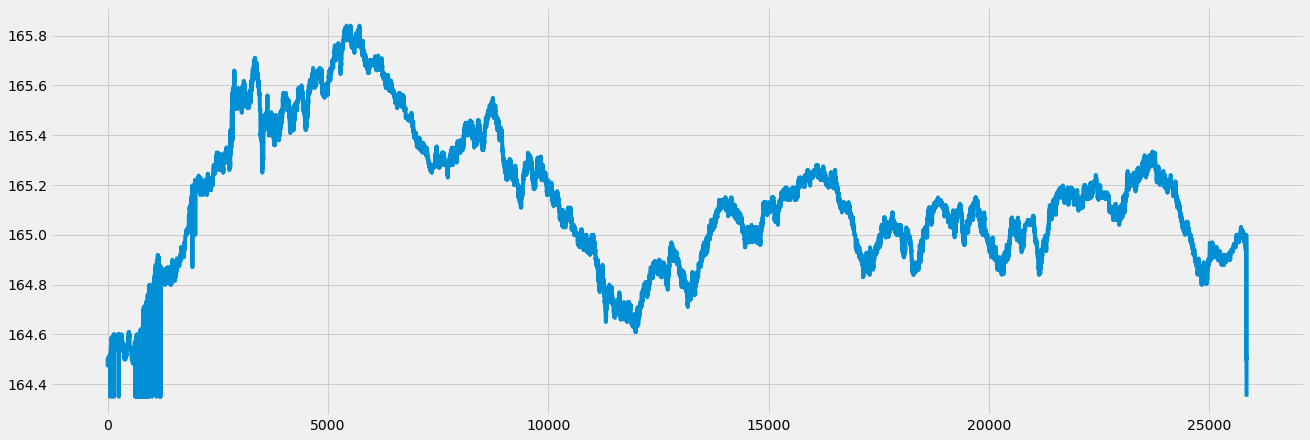

In [89]:
ticks_df = ps3.fetch_clean_trades(symbol, date='2020-02-03')

ticks_df.price.plot()

False   0.997136
True    0.002864
Name: mad_outlier, dtype: float64


<AxesSubplot:>

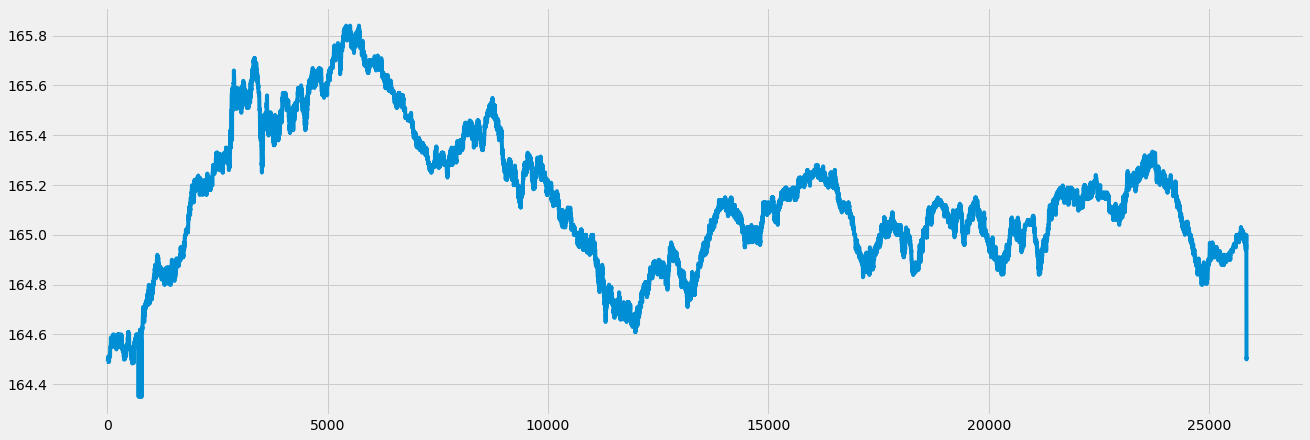

In [113]:
tdf = ft.mad_filter_df(ticks_df, value_winlen=7, devations_winlen=333, k=22)

tdf[tdf.mad_outlier == False].price.plot()

In [ ]:
tick_flter = bm.TickFilter(thresh)

tick_gens = get_tick_gen(thresh['symbol'], '2020-10-12')

In [ ]:
t = next(tick_gens)

tick, bar_sampler = tick_flter.update(
    sip_dt=t.sip_dt, 
    exchange_dt=t.exchange_dt,
    price=t.price, 
    volume=t.volume, 
    conditions=t.conditions
)

tick

In [ ]:
# bar workflow

bar_date2 = bm.bar_workflow(thresh, date='2020-12-17')

In [ ]:
bar_date['date']

tdf = bar_date['ticks_df']
bdf = pd.DataFrame(bar_date['bars'])
# lbdf = pd.DataFrame(bar_date['label_bars'])

tdf[tdf.status.str.startswith('clean_open')].plot(x='utc_dt', y='jma')
# tdf[tdf.status.str.startswith('clean_open')].plot(y='jma')

bdf.plot(x='close_at', y='jma_close')
# bdf.plot(y='jma_close')

In [ ]:
bdf.duplicated().sum() / bdf.shape[0]

In [ ]:
abs(lbdf.label_rrr).value_counts() / lbdf.shape[0]

In [ ]:
tdf.loc[:, 'epoch_sec'] = tdf.utc_dt.astype('int64') // 10**9

tdf.groupby('epoch_sec').count().price.describe(percentiles=[.8,.9,.99])

In [ ]:
# bar dates workflow

bar_dates = bm.bar_dates_workflow(thresh, ray_on=True)

# fetch and build bars

# tdf = ps3.fetch_date_df(symbol, date='2020-04-02', tick_type='trades')
# bars, tdf = bm.build_bars(ticks_df, thresh)
# bdf = pd.DataFrame(bars)

In [ ]:
n = 21
tdf = bar_dates[n]['ticks_df']
bdf = pd.DataFrame(bar_dates[n]['bars'])
print(bar_dates[n]['date'])

bdf.plot(y='jma_close')
bdf.set_index('close_at').tz_localize('UTC').tz_convert('America/New_York').plot(y='jma_close')

tdf[tdf.status.str.startswith('clean_open')].plot(x='nyc_dt', y='jma')

In [ ]:
# fill daily gaps
stacked_df = bm.fill_gaps_dates(bar_dates, fill_col='jma_wmean')

# stacked stats
stats_df = bm.stacked_df_stats(stacked_df)
stats_df.describe()

stacked_df[['jma_high','jma_low', 'jma_wmean']].plot_bokeh(sizing_mode="scale_height")

In [ ]:
results = []

for date in bar_dates:
    out = (date['ft_ticks_df'].status.value_counts() / date['ft_ticks_df'].shape[0]).to_dict()
    out.update({'date': date['date']})
    results.append(out)

pd.DataFrame(results)

In [ ]:
# rw, outlier_ind = ft.random_walk_with_outliers(0, 1000, 0.01)
# plt.plot(np.arange(len(rw)), rw)
# plt.scatter(outlier_ind, rw[outlier_ind], c='r', label='outlier')
# plt.title('Random Walk with outliers')
# plt.xlabel('Time steps')
# plt.ylabel('Values')
# plt.legend();

from bokeh.plotting import figure, output_file, show, output_notebook
# output_notebook()

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"

p1 = figure(title="Legend Example", tools=TOOLS)
p1.line(df.index, df.price)
p1.circle(df[df.mad_outlier==True].index, df[df.mad_outlier==True].price, legend_label="outlier", color="orange")

# output_file("legend.html", title="legend.py example")
show(p1, sizing_mode="scale_height")  # open a browser
